Перед началом работы над проектом импортируем необходимые инструменты:

In [1]:
# Установка и обновление необходимых библиотек:
!pip install --upgrade missingno -q
!pip install seaborn==0.13.0 -q
!pip install --upgrade scikit-learn -q
!pip install lightgbm -q
!pip install catboost -q
!pip install --upgrade phik -q

In [2]:
# Импорт необходимых библиотек и модулей:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import sklearn
import lightgbm as lgb
import catboost
import phik
import time

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 

# Импорт инструментов для подготовки данных:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    TargetEncoder
)

# Импорт инструмента подбора гиперпараметров:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate

# Импорт моделей:
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Импорт дамми-модели для проверки адекватности моделей:
from sklearn.dummy import DummyRegressor

# Импорт функции метрики:
from sklearn.metrics import root_mean_squared_error


from warnings import simplefilter

# Объявление констант:
RANDOM_STATE = 42

In [3]:
# Доп. настройка сетки для графиков:
sns.set_style("darkgrid", {'grid.color': 'gray'})

# Отключение предупреждений:
simplefilter(action='ignore', category=Warning)

## Ознакомление с данными

После импортирования необходимых инструментов считаем и сохраним полученный датасет. Далее проверим корректность считывания:

In [4]:
# Прочитаем и сохраним полученный датасет:
data = pd.read_csv('/datasets/autos.csv')

# Проверка считывания:
data.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Данные считаны и сохранены корректно. Приведём названия столбцов к корректному виду:

In [5]:
# Меняем названия столбцов:
data.columns = data.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True).str.lower()

# Проверка:
print('Новые названия стобцов:', data.columns.values)

Новые названия стобцов: ['date_crawled' 'price' 'vehicle_type' 'registration_year' 'gearbox'
 'power' 'model' 'kilometer' 'registration_month' 'fuel_type' 'brand'
 'repaired' 'date_created' 'number_of_pictures' 'postal_code' 'last_seen']


Названия столбцов приведены к корректному виду. Теперь рассмотрим общую информацию о наборе данных:

In [6]:
# Вывод общей информации в чуть более удобном виде:
print('Общая информация о датасете:\n')
print(f'Строк: {data.shape[0]}; столбцов: {data.shape[1]}\n\n')
data.info()

Общая информация о датасете:

Строк: 354369; столбцов: 16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int

Лучше привести столбцы `date_crawled`, `date_created` и `last_seen` к типу даты _datetime_. Типы данных у остальных признаков вопросов _не вызывают_. Некоторые столбцы с немалой долей пропусков. Подкорректируем типы данных и рассчитаем доли пропущенных значений:

In [7]:
# Чтобы избежать повторов, напишем функцию:
def get_datetime(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S')
    print(f'Тип данных {column}:', df[column].dtype)

In [8]:
# Применение функции:
for column in ['date_crawled', 'date_created', 'last_seen']:
    get_datetime(data, column)

Тип данных date_crawled: datetime64[ns]
Тип данных date_created: datetime64[ns]
Тип данных last_seen: datetime64[ns]


Тип данных изменили. Теперь пропуски.

In [9]:
# Выведем доли пропусков у столбцов с ними:
for column in data.columns:
    nan_perc = data[column].isna().sum() / data[column].count() * 100
    if nan_perc != 0:
        print(f'Доля пропусков в столбце {column}: {nan_perc.round(1)}%')

Доля пропусков в столбце vehicle_type: 11.8%
Доля пропусков в столбце gearbox: 5.9%
Доля пропусков в столбце model: 5.9%
Доля пропусков в столбце fuel_type: 10.2%
Доля пропусков в столбце repaired: 25.1%


Более подробно рассмотрим пропуски и возможную закономерность их появления:

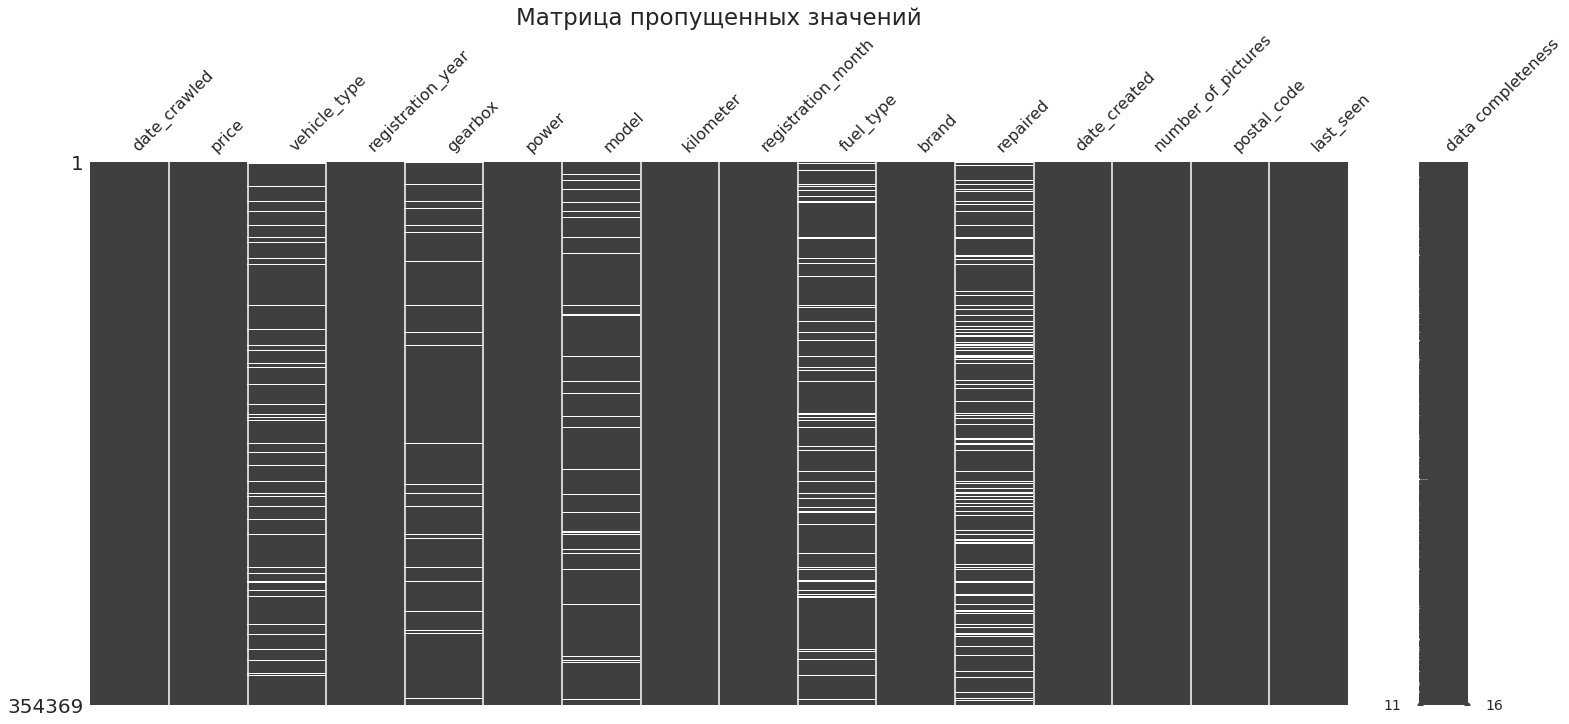

In [10]:
# Построим матрицу пропусков:
msno.matrix(data, labels=True)
plt.title('Матрица пропущенных значений', fontsize=23)

plt.show()

Какой-либо закономерности не наблюдается. Эти пропуски могли быть как и следствиями ошибок при выгрузке, так и не указанными в анкете пользователем. Можем также дополнительно рассмотреть корреляцию наличия пропуска/заполненного значения между признаками:

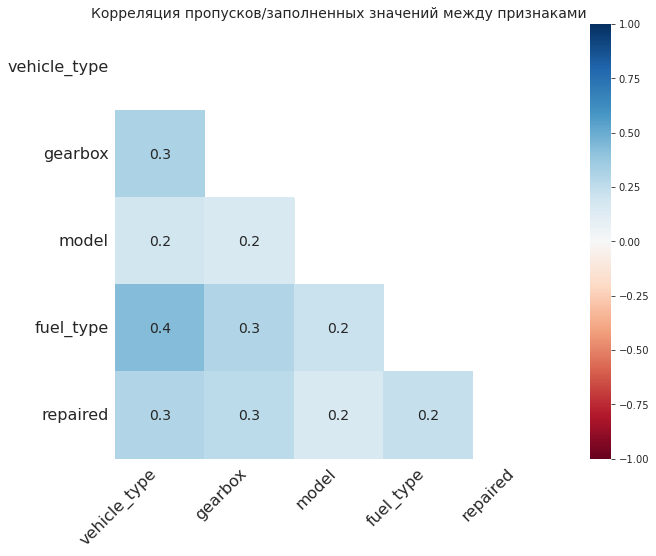

In [11]:
# Построим тепловую карту:
msno.heatmap(data, figsize=(10, 8))
plt.title('Корреляция пропусков/заполненных значений между признаками',
         fontsize=14)

plt.show()

Например, наблюдаем _умеренную_ — согласно _шкале Чеддока_ — **положительную** корреляцию наличия наблюдаемого значения между признаками `fuel_type` и `vehicle_type`. То есть, если в одном признаке присутствует непустое значение, то и в другом, скорее всего, тоже. 

Между остальными парами признаков связь либо _слабая_ (0.2 - 0.3), либо её нет вовсе.

Проверим наш датасет на наличие **явных** дубликатов.

In [12]:
print(f'Кол-во явных дубликатов: {data.duplicated().sum()}')

Кол-во явных дубликатов: 4


Избавимся от них:

In [13]:
# Вывод кол-ва строк:
print(f'Было строк: {data.shape[0]}\n')

# Убираем явные дубликаты:
data.drop_duplicates(inplace=True)

# Проверка:
print(f'Теперь строк: {data.shape[0]}')

Было строк: 354369

Теперь строк: 354365


### Вывод

На данном этапе:

- датафрейм был прочитан и сохранён;
- столбцы приведены к корректным названиям;
- выявлено наличие пропусков у ряда столбцов;
- столбцы с датой и временем были приведены к корректному формату.

Переходим к этапу предобработки данных.

## Предобработка данных

### Работа с пропусками

На прошлом этапе были выявлены пропуски в ряде столбцов. Устраним пропущенные значения.

Больше всего пропусков было выявлено в столбце `repaired`. Удалять такие данные точно не стоит, иначе мы потеряем четверть всех ценных данных для обучения, но и заполнить ничем логичным не представляется возможным. Таким образом, на месте пропусков лучше оставить значение `unknown`.

Чтобы избежать повторов и быть лаконичными, напишу функцию для замены.

In [14]:
def fill_nans(column, value='unknown', check=True):
    data[column].fillna(value=value, inplace=True)
    
    # Проверка внутри функции:
    if check == True:
        print('Кол-во пропусков:', data[column].isna().sum())
        print(f'Уникальные значения столбца {column}:', data[column].unique())

In [15]:
# Применение функции для замены пропусков:
fill_nans('repaired')

Кол-во пропусков: 0
Уникальные значения столбца repaired: ['unknown' 'yes' 'no']


Далее по количеству пропусков идёт признак `vehicle_type`. Здесь также не получится заменить на что-либо логичное, чтобы это не занимало много времени. Например, автомобиль `BMW` модели `5er`, представленной в датасете, есть в как седан, так и универсал. Можно было бы по косвенным признакам вычислить, что есть что, но таких подробных данных у нас нет. Поэтому, придётся заменить пропуски на `unknown`.

In [16]:
# Применение функции для замены пропусков:
fill_nans('vehicle_type')

Кол-во пропусков: 0
Уникальные значения столбца vehicle_type: ['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']


Далее по количеству столбец `fuel_type`. Здесь такая же ситуация, заполним на `unknown`.

In [17]:
# Применение функции для замены пропусков:
fill_nans('fuel_type')

Кол-во пропусков: 0
Уникальные значения столбца fuel_type: ['petrol' 'gasoline' 'unknown' 'lpg' 'other' 'hybrid' 'cng' 'electric']


Следом идут столбцы `model` и `gearbox` с равными долями пропусков.

- **`model`**: Удалять не хочется, чтобы не терять значительную долю данных. Заменим на _другое_ значение, например, `other` при его наличии. Всё-таки всё ещё уместна ситуация, когда пользователь при создании анкеты мог не найти нужную модель.


- **`gearbox`**: Замена на `unknown`.

In [18]:
# Столбец model
# Проверим наличие значения:
if 'other' in data['model'].unique():
    print("В столбце model была призведена замена на 'other'.")
    fill_nans('model', value='other', check=False)
else:
    print("В столбце model была призведена замена на 'unknown.'")
    fill_nans('model')

В столбце model была призведена замена на 'other'.


In [19]:
# Столбец gearbox
# Применение функции для замены пропусков:
fill_nans('gearbox')

Кол-во пропусков: 0
Уникальные значения столбца gearbox: ['manual' 'auto' 'unknown']


Таким образом, пропуски были заполнены. Посмотрим на все признаки ещё раз, чтобы в этом убедиться:

In [20]:
print('Количество пропусков в столбцах:\n')
print(data.isna().sum())

Количество пропусков в столбцах:

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64


### Неявные дубликаты

Проверим датасет на наличие неявных дубликатов. Рассмотрим перечень уникальных значений в уместных для этого столбцах. Отберём их специально написанной функцией:

In [21]:
# Отделяем категориальные (кроме дат) признаки:
def get_cat_col(df):
    cat_col = df.select_dtypes(exclude=['number', 'datetime64']).columns.tolist()
    return cat_col

In [22]:
# Сохраняем результат функции:
cat_col = get_cat_col(data)

# Проверка:
print(cat_col)

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']


Выведем перечни уникальных значений:

In [23]:
for column in cat_col:
    print(f'Уникальные значения столбца {column}:', data[column].unique(), '\n')

Уникальные значения столбца vehicle_type: ['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other'] 

Уникальные значения столбца gearbox: ['manual' 'auto' 'unknown'] 

Уникальные значения столбца model: ['golf' 'other' 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva'
 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett'
 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8'
 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo' 'focus' 'tt'
 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe' 'sportage'
 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3' 'almera'
 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 

Обнаружены подозрительные значения: `range_rover`, `rangerover`, `range_rover_sport`, `range_rover_evoque`. Проверим, какие строчки содержат их:

In [24]:
# Вносим их в отдельный список:
values_to_check = ['range_rover', 'rangerover', 'range_rover_sport', 'range_rover_evoque']

# Выведем строчки, чтобы примерно увидеть картину:
for i in range(len(values_to_check)):
    display(data[data['model'] == values_to_check[i]])
    print('\n')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
5615,2016-03-20 11:43:28,14900,suv,1993,auto,182,range_rover,150000,11,petrol,land_rover,no,2016-03-20,0,10781,2016-04-06 08:46:41
22356,2016-03-22 13:49:59,2800,suv,1996,auto,224,range_rover,150000,1,unknown,land_rover,no,2016-03-22,0,59075,2016-04-06 02:45:52
26526,2016-03-05 17:56:02,5600,suv,1982,manual,125,range_rover,5000,5,petrol,land_rover,unknown,2016-03-02,0,52068,2016-04-06 04:16:41
32216,2016-04-05 00:39:33,14950,suv,1994,auto,182,range_rover,150000,7,petrol,land_rover,no,2016-04-04,0,34123,2016-04-07 08:15:37
33834,2016-03-22 00:40:08,0,suv,1996,auto,224,range_rover,150000,2,petrol,land_rover,yes,2016-03-21,0,21217,2016-03-28 22:47:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331660,2016-03-13 10:42:51,16995,suv,2007,auto,272,range_rover,150000,4,gasoline,land_rover,no,2016-03-13,0,24360,2016-04-06 15:15:27
340882,2016-04-04 08:54:34,1500,unknown,1995,auto,224,range_rover,150000,12,petrol,land_rover,unknown,2016-04-04,0,63920,2016-04-06 09:45:48
344294,2016-03-08 14:54:18,3500,suv,1997,manual,136,range_rover,150000,1,gasoline,land_rover,no,2016-03-08,0,88400,2016-04-06 08:46:32
345351,2016-03-21 16:52:07,10999,suv,2004,auto,286,range_rover,150000,11,petrol,land_rover,no,2016-03-21,0,20251,2016-04-06 16:46:21


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
27949,2016-03-18 01:57:30,1050,small,1998,manual,103,rangerover,150000,10,petrol,rover,unknown,2016-03-18,0,49084,2016-04-05 21:18:19
117409,2016-03-24 08:54:10,16900,other,2007,auto,190,rangerover,150000,7,gasoline,rover,no,2016-03-24,0,67549,2016-04-06 23:45:08
169654,2016-03-27 21:49:44,2500,suv,1996,manual,0,rangerover,150000,0,gasoline,rover,no,2016-03-27,0,16552,2016-03-27 22:42:26
279463,2016-03-30 15:39:17,3300,unknown,2017,manual,135,rangerover,150000,2,gasoline,rover,no,2016-03-30,0,15374,2016-04-07 06:15:39


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
17863,2016-03-30 18:51:50,13250,suv,2005,auto,190,range_rover_sport,150000,6,gasoline,land_rover,no,2016-03-30,0,79877,2016-04-07 10:16:58
18667,2016-03-15 18:56:32,14700,suv,2006,auto,190,range_rover_sport,150000,7,gasoline,land_rover,no,2016-03-15,0,12109,2016-04-06 21:16:56
32874,2016-03-27 20:54:50,12700,suv,2006,auto,190,range_rover_sport,150000,6,gasoline,land_rover,no,2016-03-27,0,80339,2016-04-05 20:17:40
40830,2016-03-15 13:38:00,17900,suv,2007,auto,272,range_rover_sport,125000,3,gasoline,land_rover,no,2016-03-15,0,76530,2016-04-06 02:15:22
41941,2016-03-10 00:59:19,18900,suv,2008,auto,272,range_rover_sport,150000,10,gasoline,land_rover,no,2016-03-09,0,70569,2016-03-25 03:47:10
44976,2016-03-11 12:48:21,13000,suv,2008,auto,190,range_rover_sport,150000,2,gasoline,land_rover,no,2016-03-11,0,49356,2016-03-12 02:15:10
58105,2016-03-29 10:48:13,9500,suv,2005,auto,190,range_rover_sport,150000,12,gasoline,land_rover,no,2016-03-29,0,12351,2016-04-01 21:48:21
66565,2016-03-21 20:39:09,15200,suv,2007,auto,190,range_rover_sport,150000,6,gasoline,land_rover,no,2016-03-21,0,44147,2016-03-21 20:39:09
67948,2016-03-19 10:52:12,16600,suv,2008,auto,190,range_rover_sport,150000,2,gasoline,land_rover,no,2016-03-19,0,66798,2016-03-22 19:17:23
77505,2016-03-20 14:38:02,18499,suv,2008,auto,272,range_rover_sport,150000,3,gasoline,land_rover,no,2016-03-20,0,68723,2016-04-06 17:15:55


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
31129,2016-03-20 19:27:12,12500,suv,2005,auto,296,range_rover_evoque,150000,8,gasoline,land_rover,no,2016-03-20,0,61462,2016-03-20 20:38:44
241037,2016-03-20 12:25:21,12500,suv,2005,auto,296,range_rover_evoque,150000,8,gasoline,land_rover,no,2016-03-20,0,61462,2016-03-20 18:42:55


Значения `range_rover_sport`, `range_rover_evoque` и `range_rover` вопросов не вызывают, с ними всё в порядке. Вопросы возникают со значением `rangerover`.

Выведем строки с этим значением ещё раз для удобства:

In [25]:
data[data['model'] == values_to_check[1]]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
27949,2016-03-18 01:57:30,1050,small,1998,manual,103,rangerover,150000,10,petrol,rover,unknown,2016-03-18,0,49084,2016-04-05 21:18:19
117409,2016-03-24 08:54:10,16900,other,2007,auto,190,rangerover,150000,7,gasoline,rover,no,2016-03-24,0,67549,2016-04-06 23:45:08
169654,2016-03-27 21:49:44,2500,suv,1996,manual,0,rangerover,150000,0,gasoline,rover,no,2016-03-27,0,16552,2016-03-27 22:42:26
279463,2016-03-30 15:39:17,3300,unknown,2017,manual,135,rangerover,150000,2,gasoline,rover,no,2016-03-30,0,15374,2016-04-07 06:15:39


Дело в том, что у бренда Rover нет модели Range Rover: это детище компании Land Rover. Исправим бренд и модель у этих строк:

In [26]:
# Для дальнейшей проверки:
print('Кол-во объектов бренда land_rover до обработки:',
     data[data['brand'] == 'land_rover']['price'].count(), '\n')

# Исправление значений:
data.loc[data['model'] == 'rangerover', 'brand'] = 'land_rover'
data.loc[data['model'] == 'rangerover', 'model'] = 'range_rover'

# Проверка:
if 'rangerover' not in data['model'].unique():
    print("Значение 'rangerover' исправлено.\n")
else:
    print("Значение 'rangerover' не исправлено.\n")

    
print('Кол-во объектов бренда land_rover после обработки:',
     data[data['brand'] == 'land_rover']['price'].count())

Кол-во объектов бренда land_rover до обработки: 545 

Значение 'rangerover' исправлено.

Кол-во объектов бренда land_rover после обработки: 549


В процессе изучения информации по этим строчкам оказалось, что значение `petrol` и `gasoline` в столбце **`fuel_type`** — это синонимы. Поэтому, оставим только более привычное `gasoline`. Посмотрим, сколько строк со значением `petrol`:

In [27]:
print('Кол-во строк:', data[data['fuel_type'] == 'petrol']['price'].count())

Кол-во строк: 216349


Ого. Заменим:

In [28]:
# Замена значения-синонима:
data.loc[data['fuel_type'] == 'petrol', 'fuel_type'] = 'gasoline'

# Проверка:
print('Перечень уникальных значений fuel_type:', data['fuel_type'].unique())

Перечень уникальных значений fuel_type: ['gasoline' 'unknown' 'lpg' 'other' 'hybrid' 'cng' 'electric']


Таким образом, неявные дубликаты были обработаны. Далее нас ждёт этап EDA, на котором значения также будут "подрихтовываться".

###  Вывод

На данном этапе:

- были обработаны пропуски;
- обнаружены и обработаны неявные дубликаты;


Переходим к следующему этапу.

## EDA

Проведём исследовательский анализ полученных данных для отсева некорректных для обучения объектов.

### Количественные признаки

Для начала рассмотрим общие числовые характеристики количественных признаков:

In [29]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354365.0,4416.679830,4514.176349,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354365.0,2004.234481,90.228466,1000.0,1999.0,2003.0,2008.0,9999.0
power,354365.0,110.093816,189.851330,0.0,69.0,105.0,143.0,20000.0
kilometer,354365.0,128211.363989,37905.083858,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354365.0,5.714650,3.726432,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354365.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,354365.0,50508.503800,25783.100078,1067.0,30165.0,49413.0,71083.0,99998.0


Присутствуют как и _непрерывные_ числовые признаки (например, `price`, `power`, `kilometer`), так и _дискретные_, которые по своему поведению скорее относятся к _категориальным_ (`registration_year`, `registration_month`, `postal_code`).

Уже видно наличие некорректых значений в признаках:

- `registration_year` (минимальный и максимальный годы);

- `registration_month` (нулевой месяц, это, скорее всего, пропуск);

- `price` (минимальная цена — 0);

- `power`(минимальная и максимальные мощности);

- `number_of_pictures` (похоже, что там только одно значение).

**Начнём исследование**:

Проверим признак `number_of_pictures`.

In [30]:
# Выведем кол-во уникальных значений в признаке, чтобы убедиться:
print(f'Уникальные значения number_of_pictires: {data.number_of_pictures.unique()}')

Уникальные значения number_of_pictires: [0]


Действительно, оно единственное на все объекты. Такой признак будет абсолютно бесполезен в будущем обучении моделей. Избавимся от него:

In [31]:
# Убираем неинформативный признак из выборки:
data.drop('number_of_pictures', axis=1, inplace=True)

# Проверка:
print(f'Теперь признаков: {data.shape[1]}.')

Теперь признаков: 15.


Отлично. Напишем несколько функций для удобства анализа количественных признаков:

In [32]:
# Отделяем количественные признаки:
def get_num_col(df):
    num_col = df.select_dtypes(include='number').columns.tolist()
    return num_col

In [33]:
# Для анализа непрерывных признаков:
def num_col_analyse(df, column, xlabel, bins=10):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    # Построение гистограммы:
    axes[0].hist(df[column], bins=bins)
    axes[0].set_ylabel('Кол-во объектов', fontsize=12)
    axes[0].set_xlabel(xlabel, fontsize=12)
    axes[0].set_title('Гистограмма ' + str(column),
                     fontsize=14)
    axes[0].grid(True, color='orange')
    
    # Построение диаграммы размаха:
    axes[1].boxplot(df[column])
    axes[1].set_xlabel('Значения', fontsize=11)
    axes[1].set_title('Диаграмма размаха ' + str(column),
                     fontsize=14)
    axes[1].grid(True, color='orange')
    
    return plt.show()

In [34]:
# Доп. функция для удобства сортировки на графике:
def get_order(series):
    return series.value_counts().index

# Для распределения дискретного признака:
def discrete_graph(df, column, hue=None, xlabel='', sort=None, rot='horizontal', stat='count'):
    if sort == True:
        order = get_order(df[column])
    else:
        order = None

    countplot = sns.countplot(
        data=df, 
        x=column,
        hue=hue,
        palette='flare',
        order=order,
        stat=stat
    )
    countplot.set_xlabel(xlabel, fontsize=14)
    countplot.set_title(f'Распределение {str(column)}', fontsize=16)
    plt.xticks(rotation=rot)
    
    if stat == 'percent':
        countplot.set_ylabel('Процентов от выборки, %', fontsize=14)
    else:
        countplot.set_ylabel('Количество объектов', fontsize=14)

    return plt.show()

# Доп. настройка для размера графиков seaborn:
sns.set_theme(rc={'figure.figsize':(12,8)})

Рассмотрим признак `price`. 

Для начала, определимся с нижней границей цены. Будем считать, что самый-самый низ рынка авто это около **25_000р**, а это примерно **275 евро**, ниже уже будем считать некорректным значением. Верхнее значение в **20_000 евро** (~1млн 814тыс.р.) вопросов не вызывает.


Выведем кол-во объектов с некорректной ценой и их долю в общей выборке:

In [35]:
print('Кол-во объектов с некорректной ценой:', data[data['price'] < 275]['price'].count())
print('Их доля в датасете: ',
      ((data[data['price'] < 275]['price'].count() / data.shape[0]) * 100).round(1), '%', sep='')

Кол-во объектов с некорректной ценой: 22341
Их доля в датасете: 6.3%


Избавимся от таких объектов:

In [36]:
# Перезапишем датасет без таких значений:
data = data.query('price > 275')

# Проверка:
print(f'Кол-во строк в датасете после обработки: {data.shape[0]}')

Кол-во строк в датасете после обработки: 331971


Построим график распределения значений признака `price`:

Количественные признаки: ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'postal_code']




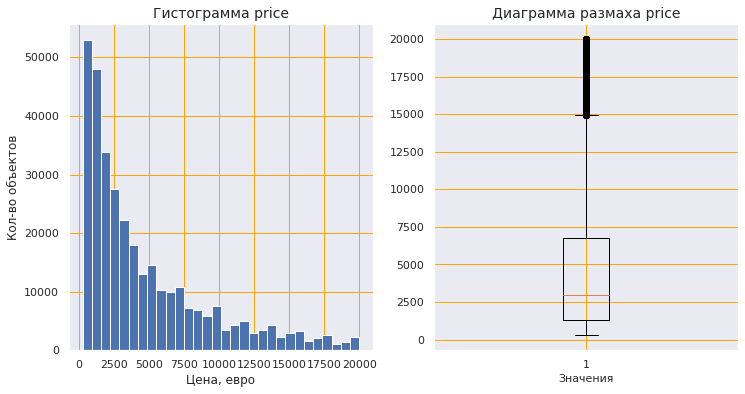

In [37]:
# Сохраним отдельно количественные признаки:
num_col = get_num_col(data)

# Вывод списка рассматриваемых признаков:
print(f'Количественные признаки: {num_col}\n\n')

num_col_analyse(data, num_col[0], 'Цена, евро', bins=30)

Больше всего объектов находится в ценовом диапазоне **до 1000** евро. Данные распределены геометрически. Имеется довольно плотное скопление значений-выбросов. _Медианное значение теперь на уровне 3000 евро_.

Следующим будет признак `power`.

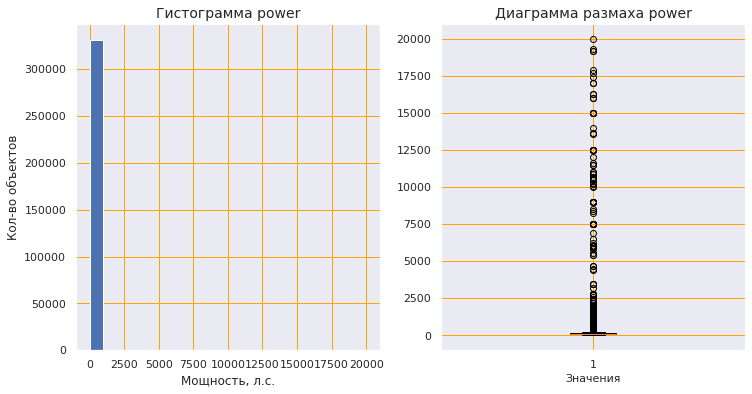

In [38]:
num_col_analyse(data, num_col[2], 'Мощность, л.с.', bins=20)

Здесь удручающая картина. Множество некорректных значений мощности. 

Определимся с диапазоном:
Возьмём за нижнюю границу **20л.с**, а за верхнюю **500 л.с**. Отфильтруем данные и рассмотрим график ещё раз:

In [39]:
# Фильтрация данных по признаку power:
data = data.query('20 <= power <= 500')

# Проверка:
print(f'Кол-во строк в датасете после обработки: {data.shape[0]}')

Кол-во строк в датасете после обработки: 299009


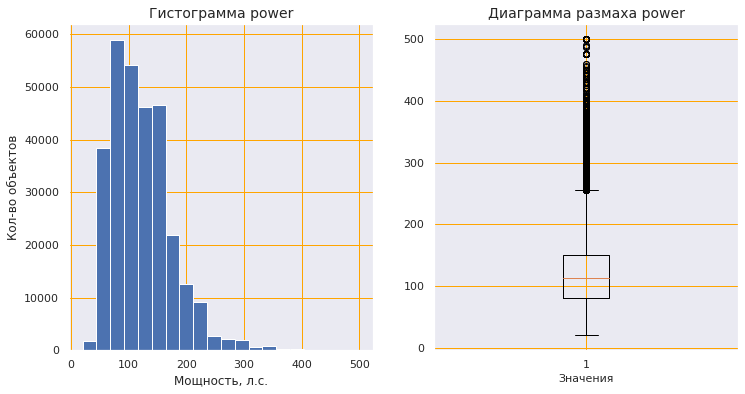

In [40]:
num_col_analyse(data, num_col[2], 'Мощность, л.с.', bins=20)

Больше всего автомобилей в настоящей выборке имеет мощность в диапазоне от 100 до 120 л.с. Распределение похоже на биномиальное. Так же имеются выбросы, которые удалять не будем, так как они находятся в пределах разумного диапазона для автомобилей.

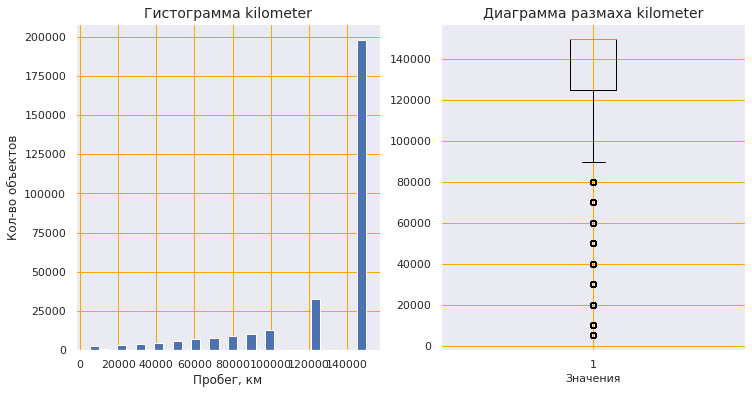

In [41]:
num_col_analyse(data, num_col[3], 'Пробег, км', bins=30)

Здесь всё ровно наоборот, чем выше значение пробега у объекта, тем чаще такие значения встречаются в выборке. За выбросы приняты значения ниже 90 тыс. км.

Ещё любопытно то, что этот признак казался количественным, а по факту значения разбиты на кластеры и поведение признака напоминает категориальный. Посмотрим, сколько вообще у него значений:

In [42]:
print('Кол-во уникальных значений kilometer:', data['kilometer'].nunique())

Кол-во уникальных значений kilometer: 13


И значений в нём, как в обычном категориальном признаке... Лучше рассмотрим такой признак другим графиком.

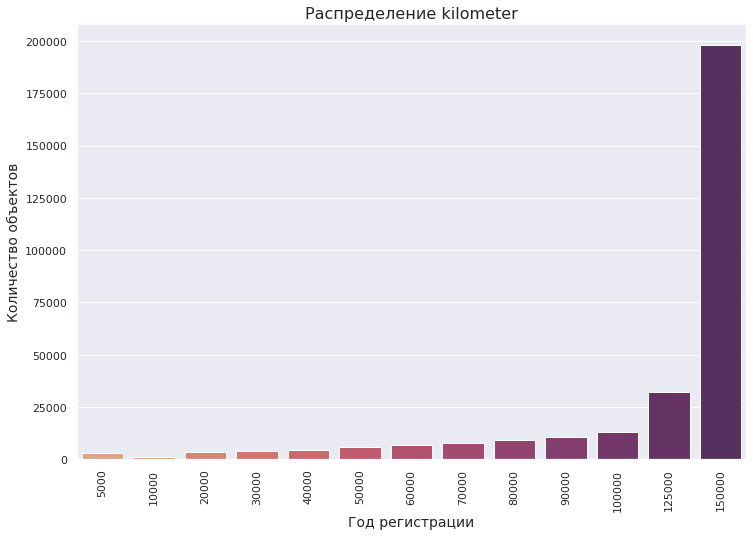

In [43]:
# Построение графика:
discrete_graph(
    data,
    'kilometer',
    xlabel='Год регистрации',
    rot='vertical'
)

Можно также рассмотреть, как распределён факт ремонта в зависимости от пробега.

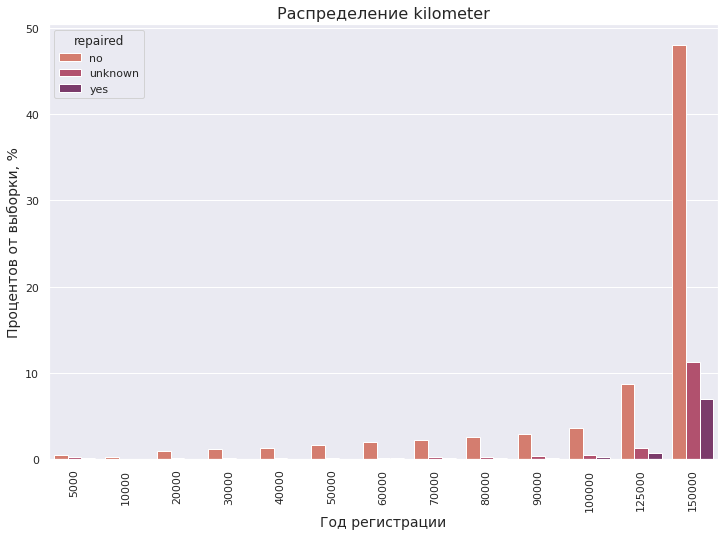

In [44]:
# Построение графика:
discrete_graph(
    data,
    'kilometer',
    hue='repaired',
    xlabel='Год регистрации',
    rot='vertical',
    stat='percent'
)

Ничего необычного. В сравнении масштабов ни одна из групп особо не выделяется.

Рассмотрим признак `registration_year`:

Так как все эти данные взяты из анкет пользователей, автомобиль не может быть зарегистрирован позже даты скачивания этой анкеты из базы для данного проекта. Используя эту информацию, мы можем определить год и и месяц _верхней_ границы диапазона корректных значений признака.

Объекты, у которых год регистрации и месяц регистрации будут позже фактического скачивания их анкет из базы, будут некорректными.

In [45]:
print('Верхняя граница диапазона (год):', data['date_crawled'].max().year)
print('Верхняя граница диапазона (месяц):', data['date_crawled'].max().month)

Верхняя граница диапазона (год): 2016
Верхняя граница диапазона (месяц): 4


Отлично. За нижнюю возьмём **1980г**. Отфильтруем исходный датасет и построим график для данного _дискретного_ признака.

In [46]:
# Фильтрация данных по признаку registration_year:
data = data.query('1980 <= registration_year <= 2016')
# Дополнительно фильтруем верхнюю границу по месяцу:
data = data[~((data['registration_year'] == 2016) & (data['registration_month'] > 4))]

# Проверка:
print(f'Кол-во строк в датасете после обработки: {data.shape[0]}')

Кол-во строк в датасете после обработки: 283653


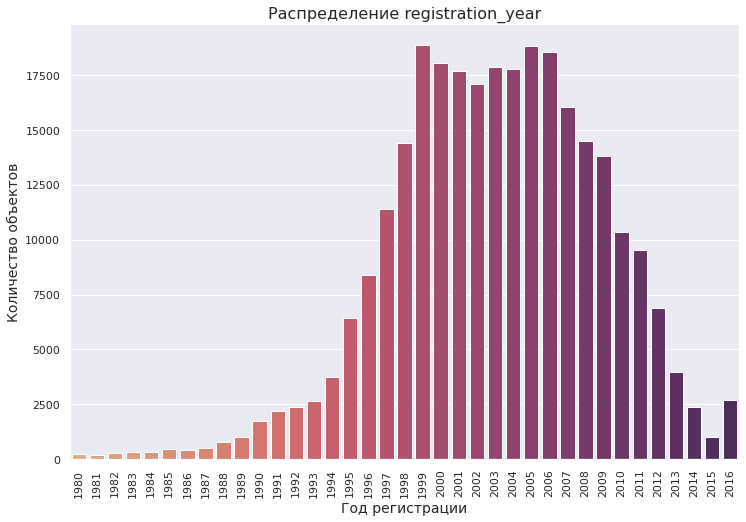

In [47]:
# Построение графика для дискретного признака:
discrete_graph(
    data,
    'registration_year',
    xlabel='Год регистрации',
    rot='vertical'
)

_Больше_ всего автомобилей из выборки было зарегистрировано в **1999** году. На втором месте 2005 и 2006 годы.
_Меньше_ всего было зарегистрировано в **1981**г.

Рассмотрим признак `registration_month`.

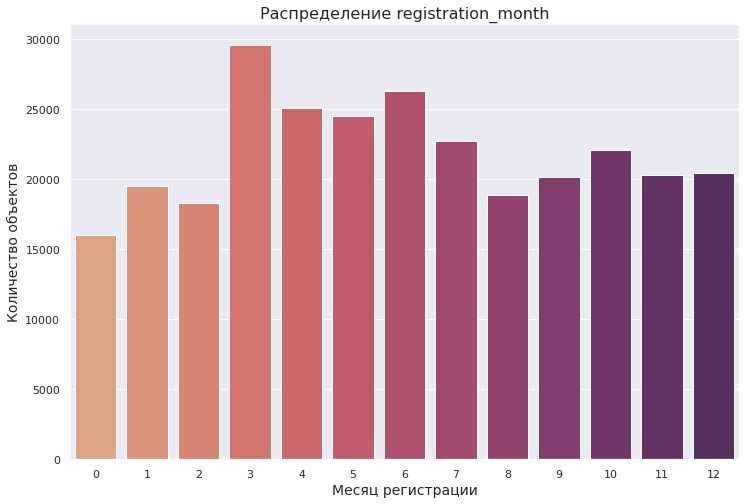

In [48]:
# Построение графика для дискретного признака:
discrete_graph(
    data,
    'registration_month',
    xlabel='Месяц регистрации'
)

Больше всего авто из выборки зарегистрировали в марте (третий месяц). Значительную долю занимают пропуски (значение `0`). Заполним их округлённым средним значением по всей выборке.

In [49]:
# Замена на среднее по выборке:
data.loc[data['registration_month'] == 0, 'registration_month'] = \
int(data['registration_month'].mean().round())

После замены можем оценить картину повторно:

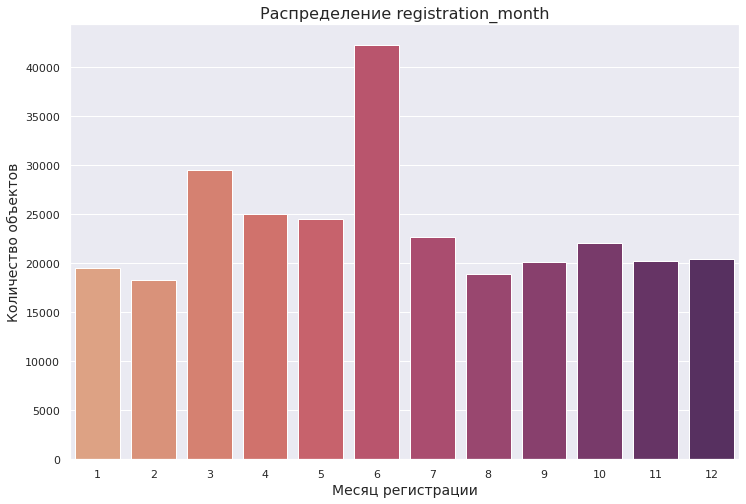

In [50]:
# Построение графика для дискретного признака:
discrete_graph(
    data, 
    'registration_month',
    xlabel='Месяц регистрации'
)

Как и ожидалось, теперь лидирует июнь. Заодно избавились от некорректного значения.

Переходим к признаку `postal_code`. Посмотрим на его количество уникальных значений.

In [51]:
print('Кол-во уникальных значений postal_code:', data['postal_code'].nunique())

Кол-во уникальных значений postal_code: 8106


Признак хоть и категориальный, но количество "категорий" зашкаливает. Вот только нужно ли их столько? Можно поступить следующим образом:

Согласно информации из открытых источников, с 1971 года на территории РФ введён _шестизначная_ система почтовых индексов. Первые три цифры означают код региона и города, а последние — код района и почтового отделения. Район и конкретное почтовое отделение нам вряд ли нужны, поэтому можно оставить только **первые три цифры** почтового индекса.

Но с другой стороны, согласно первичным числовым характеристикам в начале этого раздела, ни одно из значений в выборке не является шестизначным. Убедимся в этом ещё раз.

In [52]:
print(f'Диапазон индексов от {data.postal_code.min()} до {data.postal_code.max()}.')

Диапазон индексов от 1067 до 99998.


С этим уже ничего не поделаешь, будем работать с тем, что есть. Оставим только первые три цифры от каждого индекса. Для начала сменим тип на строковый, чтобы дальше их "обрезать".

In [53]:
# Смена типа данных столбца на строковый:
data['postal_code'] = data['postal_code'].astype('str')

# Проверка:
print(f'Тип столбца postal_code: {data.postal_code.dtype}')

Тип столбца postal_code: object


"Урежем" значения только до первых трёх цифр:

In [54]:
# Воспользуемся для этого циклом:
cut_values = []

for value in data['postal_code']:
    value = value[:3]
    cut_values.append(value)
    
data['postal_code'] = cut_values
    
# Проверка:
print(f'Диапазон индексов от {data.postal_code.min()} до {data.postal_code.max()}.')
print('Кол-во уникальных значений postal_code:', data['postal_code'].nunique())

Диапазон индексов от 101 до 999.
Кол-во уникальных значений postal_code: 711


Таким образом, мы уменьшили количество категорий. Смотреть график распределения особого смысла не имеет, так как значений все равно слишком много. Можно обратно вернуть числовой тип.

In [55]:
# Смена типа данных столбца обратно на числовой:
data['postal_code'] = data['postal_code'].astype('int64')

# Проверка:
print(f'Тип столбца postal_code: {data.postal_code.dtype}')

Тип столбца postal_code: int64


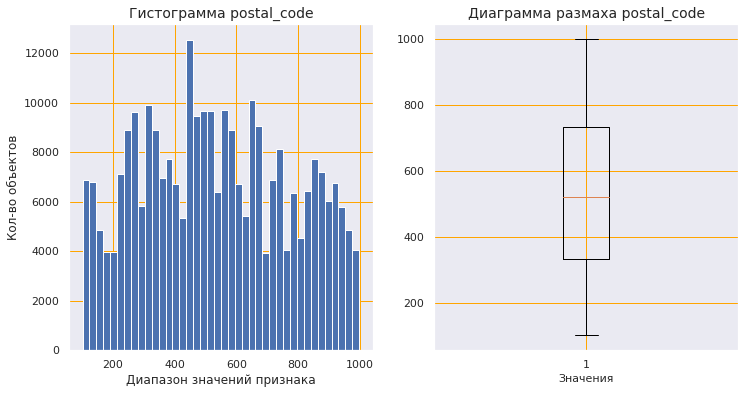

In [56]:
# Построение графика:
num_col_analyse(data, 'postal_code', 'Диапазон значений признака', bins=40)

Значения распределены почти равномерно. Больше об этом признаке сказать нечего.
Добавим этот признак в список категориальных:

In [57]:
# Занесение в кат. признаки:
cat_col.append('postal_code')
# Удаляем его из количественных:
num_col.remove('postal_code')

### Категориальные признаки

Рассмотрим признаки, которые будем анализировать:

In [58]:
# Вывод списка рассматриваемых признаков:
print(f'Категориальные признаки: {cat_col}')

Категориальные признаки: ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired', 'postal_code']


Начнём с `vehicle_type`.

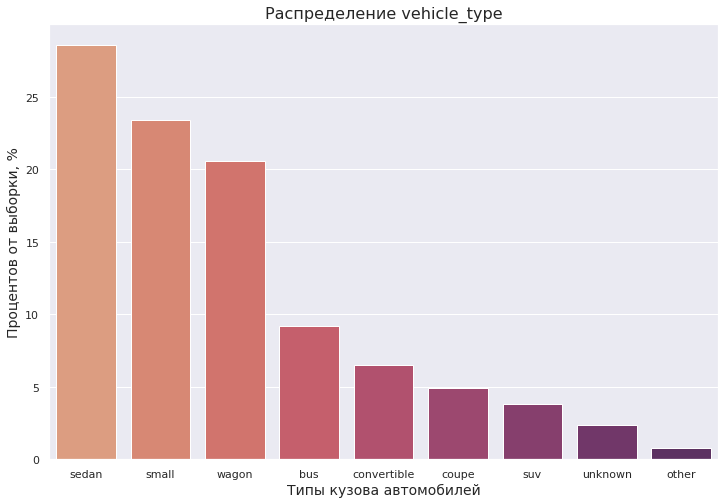

In [59]:
# Построение графика:
discrete_graph(
    data, 
    cat_col[0],
    xlabel='Типы кузова автомобилей',
    rot='horizontal',
    stat='percent',
    sort=True
)

В датасете больше всего представлено объектов с типом кузова _«седан»_(почти 30% от выборки), далее идёт тип кузова «small» (23% от выборки). Неизвестный тип и «другой» тип представлены меньше всех, что хорошо для обучения.

Рассмотрим признак с коробками передач `gearbox`.

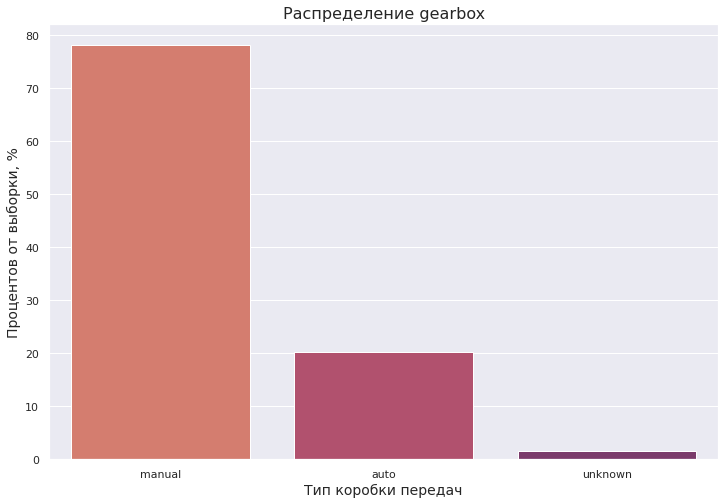

In [60]:
# Построение графика:
discrete_graph(
    data, 
    cat_col[1],
    xlabel='Тип коробки передач',
    rot='horizontal',
    stat='percent',
    sort=True
)

Подавляющее большинство объектов представлены с _механической_ КПП (почти 80%), далее идут _автоматические_ КПП (20%).

Рассмотрим модели, признак `model`. Выведем количество представленных моделей:

In [61]:
print(f'Всего представленно уникальных моделей авто: {data.model.nunique()}')

Всего представленно уникальных моделей авто: 247


Количество немалое. Поэтому рассмотрим только топ-5.

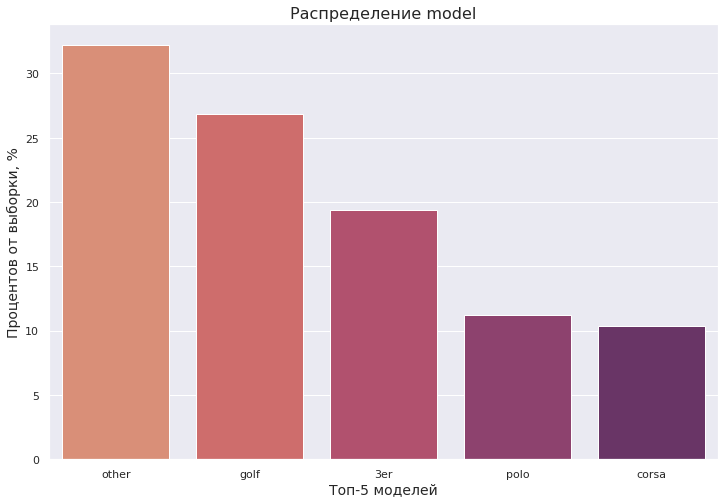

In [62]:
# Топ-5 представленных моделей:
top5_models = data['model'].value_counts().index[:5]

# Построение графика по срезу:
discrete_graph(
    data[data['model'].isin(top5_models)], 
    cat_col[2],
    xlabel='Топ-5 моделей',
    stat='percent',
    sort=True
)

На первом месте идёт необъявленный _«другой»_ тип модели. Далее ~27% от выборки занимает модель _«golf»_ (Volkswagen Golf, судя по всему), за ним идёт BMW _«3er»_ (третьей серии), 19%.

Переходим к типу топлива `fuel_type`.

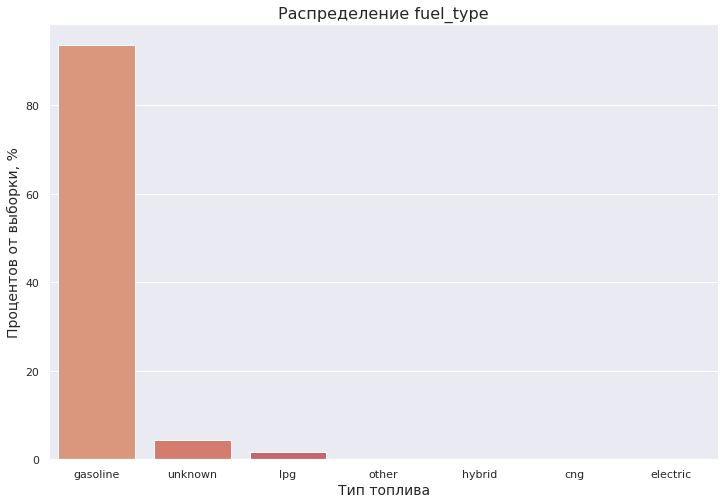

In [63]:
# Построение графика:
discrete_graph(
    data, 
    cat_col[3],
    xlabel='Тип топлива',
    stat='percent'
)

Абсолютным лидером по представлению в выборке (почти **90**%) является _бензиновое_ топливо. Оастальные типы почти не представлены.

Рассмотрим ситуацию по брендам, признак `brand`.

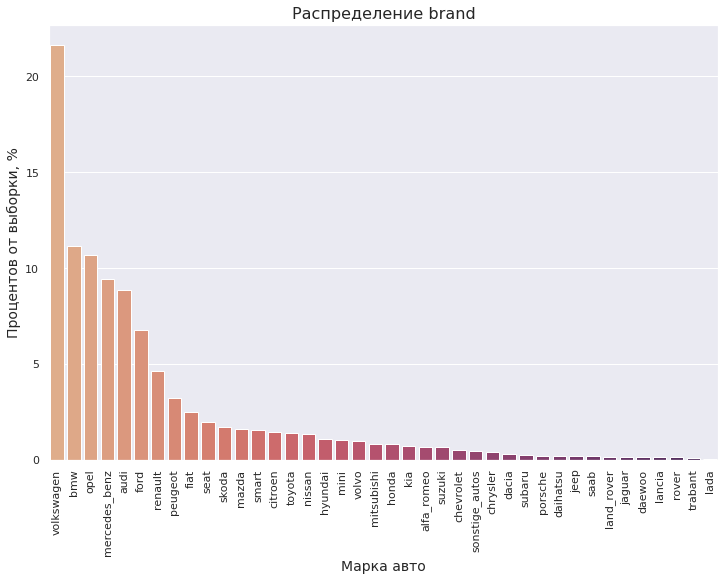

In [64]:
# Построение графика:
discrete_graph(
    data, 
    cat_col[4],
    xlabel='Марка авто',
    stat='percent',
    rot='vertical',
    sort=True
)

Абсолютный лидер — бренд `Volkswagen` (23%), За ним идут `BMW` (11%) и `Opel` (10.5%). Меньше всего объектов марки `Lada`.

Посмотрим, как обстоят дела с фактом ремонта у автомобилей, признак `repaired`.

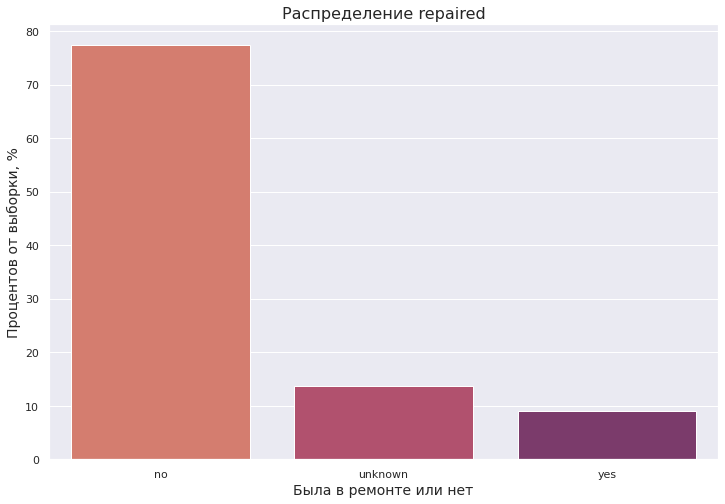

In [65]:
# Построение графика:
discrete_graph(
    data, 
    cat_col[5],
    xlabel='Была в ремонте или нет',
    stat='percent',
    sort=True
)

Абсолютное большинство (**~77%**) пользователей указали в анкетах, что авто не был в ремонте. Дополнительно можно рассмотреть, как распределён факт ремонта по маркам авто:

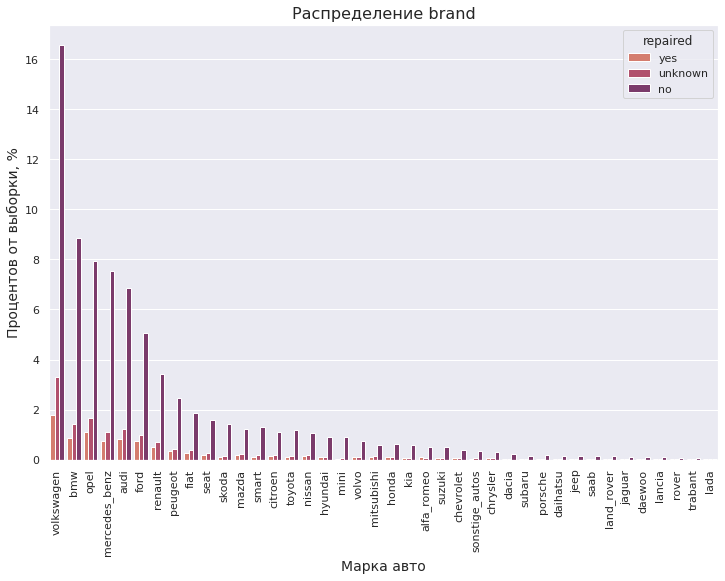

In [66]:
# Построение графика:
discrete_graph(
    data,
    'brand',
    'repaired',
    xlabel='Марка авто',
    rot='vertical',
    sort=True,
    stat='percent'
)

В целом, никакая марка не выделяется фактами ремонта.

### Вывод

На данном этапе было проведено исследование признаков. **Основные моменты**:

1. Избавились от целого бесполезного признака `number_of_pictures`;


2. Мы избавились от некорректных значений в признаках `price`, `registration_year`, `registration_month`, `power`;


3. Снизили количество категорий признака `postal_code`;


4. В связи с вышеназванными пунктами, данные стали ещё более благоприятными для корректного обучения моделей;


5. Больше всего в выборке автомобилей с пробегом **более 140 тысяч км**, и чем пробег _меньше_, тем _меньше_ таких автомобилей;


6. Больше всего авто находится в ценовом диапазоне **до 1000 евро**;


7. Больше всего автомобилей в настоящей выборке имеет мощность в диапазоне **от 100 до 120 л.с**;


8. Лучше всего представлены _седаны_, из КПП — _механическая_, по марке — _Volkswagen_, _BMW_ и _Opel_;


9. Самый распространённый тип топлива — бензиновое топливо;


10. Абсолютное большинство объектов выборки не были в ремонте, по заявлению владельцев анкет;


Cамое время перейти к корреляционному анализу данных, чтобы проверить их на мультиколлинеарность.

## Корреляционный анализ

Для удобства построим матрицу корреляции по коэффициенту Фи в виде тепловой карты, которая поможет нам наглядно увидеть степень корреляционных связей признаками. Интерпретировать степень корреляции будем согласно _шкале Чеддока_.

Для начала напишем функцию для визуализации матрицы корреляции (МК):

In [67]:
# Функция для визуализации МК:
def correlation_matrix(df, interval_cols=None):

    # Формирование матрицы корреляции:
    phik_overview = phik_matrix(df, interval_cols=interval_cols)

    return plot_correlation_matrix(
            phik_overview.values,
            x_labels=phik_overview.columns,
            y_labels=phik_overview.index,
            vmin=0, vmax=1, color_map='Greens',
            title=(r'Матрица корреляции $\phi_K$'),
            fontsize_factor=1.5,
            figsize=(20, 15)
            )

Построим матрицу корреляции для нашего датасета, не включая временны́е признаки:

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'postal_code']


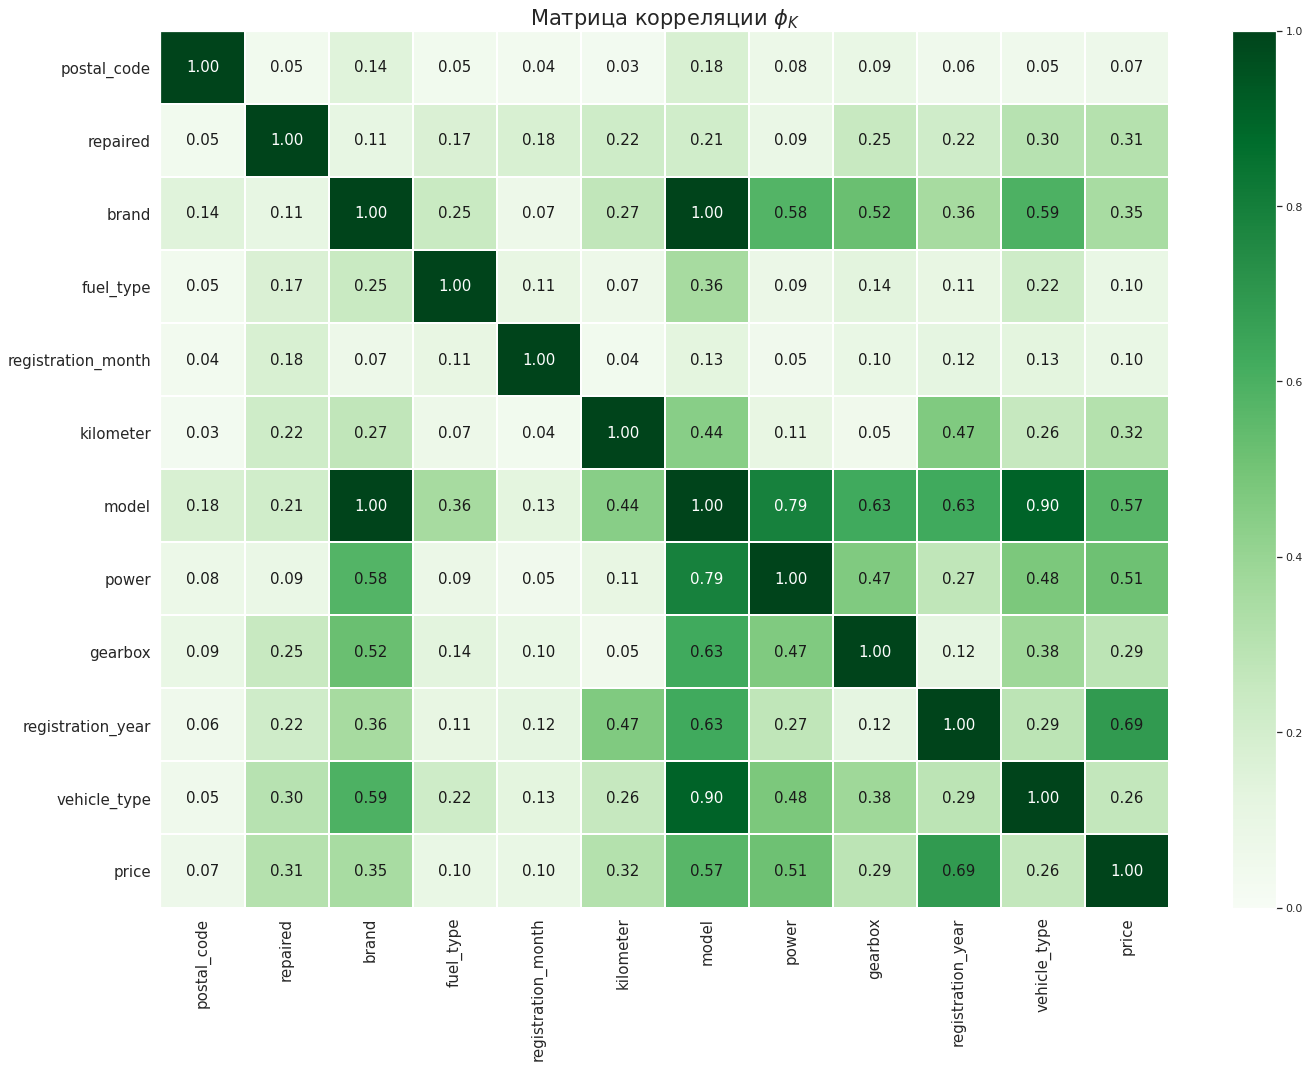

In [68]:
# Выделяем временные признаки:
date_col = data.select_dtypes(include='datetime').columns

# Построение МК:
correlation_matrix(data.drop(date_col, axis=1))

_Наблюдается мультиколлинеарность_.

Входные признаки `brand` и `model` обладают _весьма высокой_ степенью корреляции. Один из них необходимо убрать для качества обучения модели.

Также _весьма высокой_ степенью корреляции обладают признаки `vehicle_type` и `model`, что тоже логично, ведь модели могут выпускаться в определённых типах кузова.

_Высокую_ корреляцию между `power` и `model` также можно объяснить этими же причинами. _Заметной_ корреляцией обладает целевой признак `price` и входной `registration_year`.

Нам придётся избавиться от признака `brand`, так как мы имеем более информативный признак `model`.

In [69]:
# Убираем неинформативный признак:
data = data.drop('brand', axis=1)

# Проверка:
print('Теперь входных признаков:', len(data.drop('price', axis=1).columns))

Теперь входных признаков: 13


Рассмотрим несколько признаков отдельно с помощью диаграмм рассеивания, чтобы оценить их полезность на ценообразование:

In [70]:
# Функция для построения диаграммы рассеяния:
def custom_scatterplot(data, x, y='price', ylabel='Целевой признак, цена (евро)'):
    sns.scatterplot(
        data,
        x=x,
        y=y
    )
    plt.ylabel(ylabel)
    plt.title(f'Диаграмма рассеяния {x} / price', fontsize=15)
    plt.xticks(fontsize=9)

    return plt.show()

Выделим отдельно временные признаки:

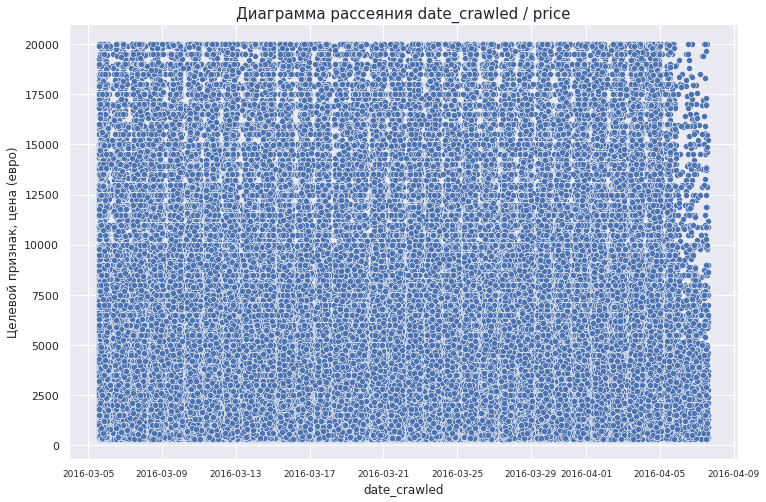

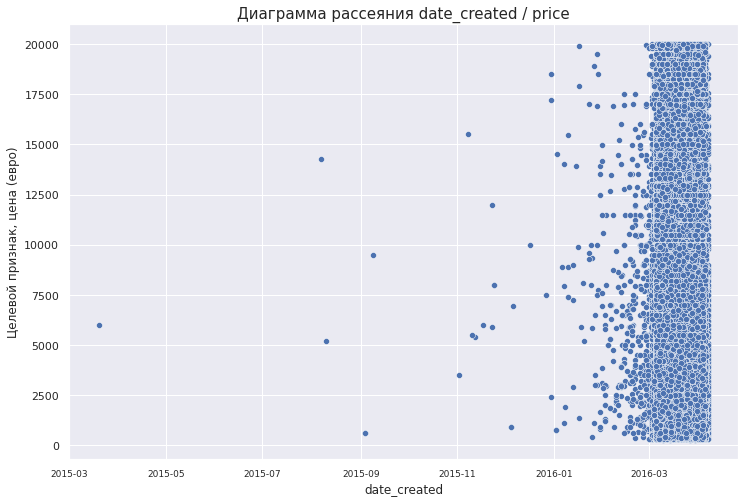

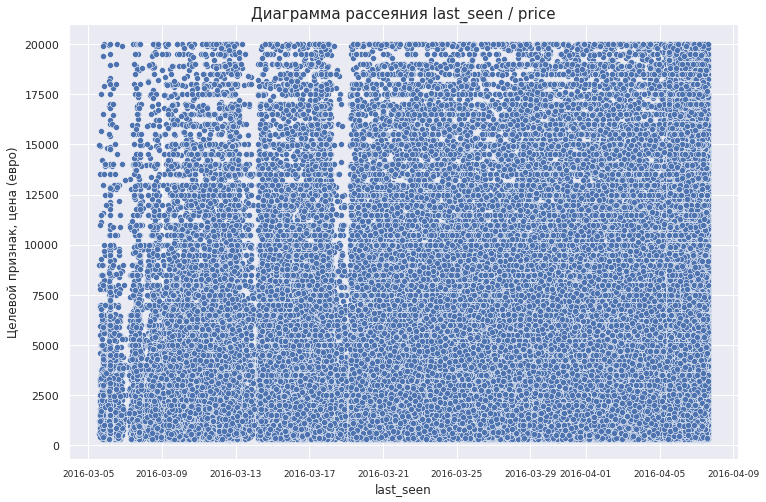

In [71]:
# Выделяем временные признаки:
date_col = data.select_dtypes(include='datetime').columns

# Построим ДР с помощью цикла:
for column in date_col:
    custom_scatterplot(data, column)

Очень шумные данные, которые только затруднят обучение модели. Лучше их убрать.

In [72]:
# Убираем шумные признаки:
data = data.drop(date_col, axis=1)

# Проверка:
print('Теперь входных признаков:', len(data.drop('price', axis=1).columns))

Теперь входных признаков: 10


Под вопросом и полезность признака `registration_month`. Рассмотрим:

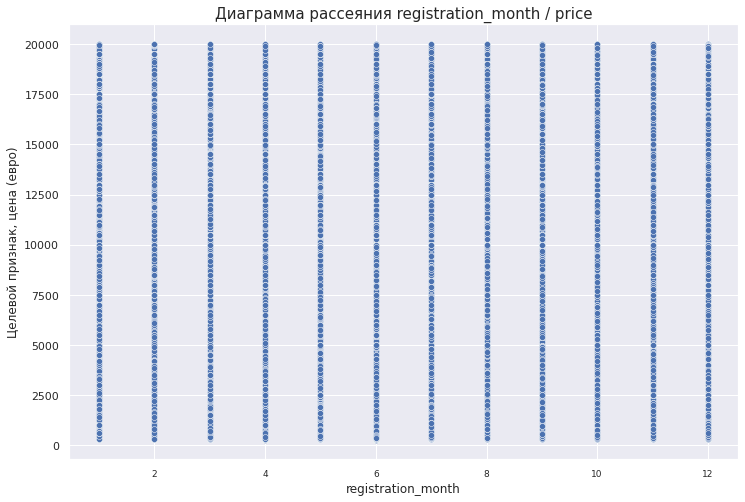

In [73]:
custom_scatterplot(data, 'registration_month')

Похоже, этот признак не влияет на цены. Уберём его:

In [74]:
# Убираем шумные признаки:
data = data.drop('registration_month', axis=1)

# Проверка:
print('Теперь входных признаков:', len(data.drop('price', axis=1).columns))

Теперь входных признаков: 9


Также под вопросом важность признака `postal_code`. Посмотрим его диаграмму рассеяния:

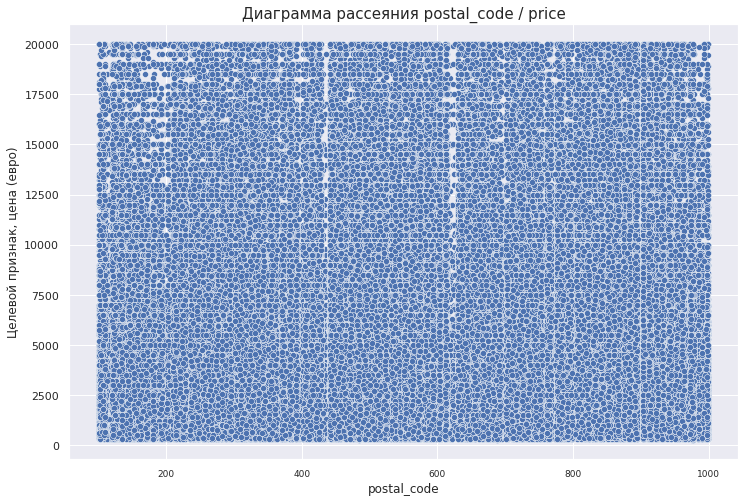

In [75]:
# Построение ДР:
custom_scatterplot(data, 'postal_code')

Ничего не разобрать, шумный признак. Наверное, стоит убрать его.

In [76]:
# Убираем шумные признаки:
data = data.drop('postal_code', axis=1)

# Проверка:
print('Теперь входных признаков:', len(data.drop('price', axis=1).columns))

Теперь входных признаков: 8


Чем больше признаков мы убираем, тем выше вероятность, что строки в новом датасете окажутся **явными** дубликатами. Проверим наличие явных дубликатов и удалим их при наличии.

In [77]:
if data.duplicated().sum() != 0:
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    
    # Убираем явные дубликаты:
    data.drop_duplicates(inplace=True)
    # Проверка:
    print(f'Дубликаты удалены, теперь их: {data.duplicated().sum()}')
    print(f'Новое кол-во строк: {data.shape[0]}')

else:
    print('Явных дубликатов не обнаружено.')

Количество явных дубликатов: 39199
Дубликаты удалены, теперь их: 0
Новое кол-во строк: 244454


In [78]:
# Убираем признаки:
cat_col.remove('brand')
cat_col.remove('postal_code')
num_col.remove('price')
num_col.remove('registration_month')

### Вывод

1. Была обнаружена _мультиколлинеарность_. Её мы устранили. 
2. Убрали шумные признаки.
3. Убрали новые явные дубликаты.

## Подготовка данных

Пробовать будем следующие модели: DecisionTreeRegressor, LGBMRegressor и CatBoostRegressor.

У нас есть как числовые-непрерывные, так и категориальные признаки. Рассмотрим, сколько уникальных значений в наших категориальных признаках:

In [79]:
pd.DataFrame(
    data[cat_col].nunique().sort_values(ascending=False),
    columns=['value_quantity']
)

,value_quantity
model,247
vehicle_type,9
fuel_type,7
gearbox,3
repaired,3


Мы имеем _низкокардинальные_ признаки `gearbox`, `repaired`, `fuel_type` и `vehicle_type`. Их будем кодировать с помощью `OneHotEncoder`.

_Высококардинальный_ признак `model` будем кодировать с помощью `TargetEncoder`.

In [80]:
# Отделим признаки по способам кодирования:

# Признаки для кодирования OneHotEncoder:
ohe_col = ['repaired', 'fuel_type', 'gearbox', 'vehicle_type']

# Признак для кодирования TargetEncoder:
te_col = ['model']

Разделим данные на выборки с помощью функции:

In [81]:
# Функция для разделения на выборки:
def get_samples(df, target, test_size, random_state=RANDOM_STATE):
    
    # Делим данные на входные и целевые:
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state
    )
        
    X_valid, X_test, y_valid, y_test = train_test_split(
        X_valid,
        y_valid,
        test_size=.5,
        random_state=random_state
    )
    
    # Проверка:
    print('Размер тренировочной выборки: {:.0%}'.format(X_train.shape[0] / X.shape[0]))
    print('Размер валидационной выборки: {:.0%}'.format(X_valid.shape[0] / X.shape[0]))
    print('Размер тестовой выборки: {:.0%}'.format(X_test.shape[0] / y.shape[0]))
        
        
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [82]:
# Формируем выборки:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_samples(
    data,
    'price',
    test_size=0.4,
    random_state=RANDOM_STATE
)

Размер тренировочной выборки: 60%
Размер валидационной выборки: 20%
Размер тестовой выборки: 20%


Сформируем пайплайн, в котором передадим сформированные выборки для дальнейшего их кодирования и передаче модели:

In [83]:
# Шаг 1: OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)


# Шаг 2: TargetEncoder
te_pipe = Pipeline(
    [
        (
            'simpleImputer_before_te', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'te', TargetEncoder(target_type='continuous', random_state=RANDOM_STATE)
        ),
        (
            'simpleImputer_after_te', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# Объединение подготовок кат. и кол. признаков
# в общий шаг подготовки данных:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('te', te_pipe, te_col)  
    ], 
    remainder='passthrough'
)

# Итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

### Промежуточные итоги

На данном этапе мы подготовили выборки и сформировали пайплайн, в который они будут переданы на следующем этапе.

## Обучение моделей

Для оценки качества моделей будем применять метрику **RMSE**.
Согласно требованию заказчика, значение метрики RMSE должно быть _меньше 2500_.

Но также для заказчика важен критерий _скорости_. Будем замерять время выполнения обучения и предсказания конкретных моделей с помощью модуля `time` и встроенных инструментов в RandomizedSearchCV.

### DecisionTreeRegressor

Начнём с модели дерева решений. Подберём наиболее удачный набор параметров с помощью инструмента `RandomizedSearchCV`.

In [84]:
# Определим диапазоны параметров модели для поиска:
rs_params = {
    'models__max_depth': range(2, 16),
    'models__min_samples_split': range(2, 16)
}

# Инициализация инструмента подбора:
rs = RandomizedSearchCV(
    pipe_final,
    rs_params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5,
    n_iter=10,
    random_state=RANDOM_STATE
)

Гиперпараметры задали, теперь запустим их подбор и узнаем лучшее их сочетание:

In [85]:
# Запуск подбора:
rs.fit(X_train, y_train)

# Вывод результатов:
print('Лучшие гиперпараметры модели:\n\n', rs.best_params_)
print('\n\nМетрика RMSE лучшей модели на кросс-валидации:',
      abs(rs.best_score_.round(2)))

Лучшие гиперпараметры модели:

 {'models__min_samples_split': 15, 'models__max_depth': 11}


Метрика RMSE лучшей модели на кросс-валидации: 1892.35


Мы выявили лучшую модель. Сохраним её результаты отдельно:

In [86]:
# Сохраним время её обучения:
tree_fit_time = rs.cv_results_['mean_fit_time'][rs.best_index_].round(3)

# Сохраним время её предсказаний + расчёт метрики:
tree_score_time = rs.cv_results_['mean_score_time'][rs.best_index_].round(3)

# Сохраним значение её метрики:
tree_score = abs(rs.best_score_.round(2))

Проверим модель на адекватность с помощью дамми-модели. Для удобства дальнейших проверок, напишем функцию:

In [87]:
# Функция для проверки модели:
def check_model(train_x, train_y, metric):
    # Инициализация дамми-модели:
    dummy_regressor = DummyRegressor()
    
    # Обучение модели:
    dummy_regressor.fit(train_x, train_y)

    # Получение предсказаний:
    dummy_pred = dummy_regressor.predict(X_valid)

    # Получение метрики:
    rmse_dummy = root_mean_squared_error(y_valid, dummy_pred)
    
    # Презентация результатов:
    print('Метрика RMSE дамми-модели на валидационной выборке:',
      round(rmse_dummy, 2), '=>')
    
    if rmse_dummy > metric:
        print('=> Модель прошла проверку на адекватность.')
    else:
        print('=> Модель НЕ прошла проверку на адекватность.')

In [88]:
# Проверка модели:
check_model(X_train, y_train, tree_score)

Метрика RMSE дамми-модели на валидационной выборке: 4690.32 =>
=> Модель прошла проверку на адекватность.


### LGBMRegressor

Продолжаем обучение моделей. Следующей на очереди у нас `LGBMRegressor`, основанная на бустинге. Попробуем установить гиперпараметры `num_leaves` (кол-во листьев дерева решений), `learning_rate` (скорость обучения) и `reg_alpha` (L1, лассо-регуляризация).

Перед тем, как начинать с ней работать, преобразуем категориальные признаки в тип `category`, чтобы затем передать их модели для её собственного кодирования.

In [89]:
copied_data = data.copy()

# Изменим тип данных с помощью цикла:
for column in cat_col:
    copied_data[column] = copied_data[column].astype('category')
    
# Проверка:
print('Новые типы данных у признаков:\n\n', copied_data.dtypes)

Новые типы данных у признаков:

 price                   int64
vehicle_type         category
registration_year       int64
gearbox              category
power                   int64
model                category
kilometer               int64
fuel_type            category
repaired             category
dtype: object


Сформируем для неё выборки ещё раз:

In [90]:
# Формируем выборки:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_samples(
    copied_data,
    'price',
    test_size=0.4,
    random_state=RANDOM_STATE
)

Размер тренировочной выборки: 60%
Размер валидационной выборки: 20%
Размер тестовой выборки: 20%


Произведём инициализацию модели, зададим значения её гиперпараметров:

In [91]:
# Инициализация модели:
lgb_model = lgb.LGBMRegressor(
    n_estimators=30,
    learning_rate=0.09,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    categorical_features=cat_col
)

После того, как мы определили модель, запустим для неё процесс кросс-валидации. Перед этим создадим словарь с параметрами, куда передадим _валидационную_ выборку и метрику, которая будет на ней измеряться. Эти параметры будут передаты методу для обучения `fit` внутри процесса кросс-валидации.

In [92]:
# Задаём параметры для метода fit:
fit_params = {
    'eval_set': (X_valid, y_valid),
    'eval_metric': 'rmse',
    'verbose': 15
}

In [93]:
# Запускаем кросс-валидацию и сохраняем результаты:
lgb_result = cross_validate(
    lgb_model,
    X_train,
    y_train,
    params=fit_params,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

[15]	valid_0's rmse: 2236.67	valid_0's l2: 5.00269e+06
[30]	valid_0's rmse: 1779.24	valid_0's l2: 3.16571e+06
[15]	valid_0's rmse: 2239.89	valid_0's l2: 5.01709e+06
[30]	valid_0's rmse: 1780.84	valid_0's l2: 3.17139e+06
[15]	valid_0's rmse: 2240.6	valid_0's l2: 5.02027e+06
[30]	valid_0's rmse: 1779.45	valid_0's l2: 3.16645e+06
[15]	valid_0's rmse: 2239.29	valid_0's l2: 5.01442e+06
[30]	valid_0's rmse: 1779.65	valid_0's l2: 3.16714e+06
[15]	valid_0's rmse: 2238.73	valid_0's l2: 5.01193e+06
[30]	valid_0's rmse: 1779.14	valid_0's l2: 3.16535e+06


Результаты были получены. Сохраним отдельно их усреднённое значение. Дополнительно проверим модель на адекватность.

In [94]:
# Сохраним время её обучения:
lgb_fit_time = lgb_result['fit_time'].mean().round(3)

# Сохраним время её предсказаний + расчёт метрики:
lgb_score_time = lgb_result['score_time'].mean().round(3)

# Сохраним значение её метрики:
lgb_score = abs(lgb_result['test_score'].mean().round(2))

In [95]:
# Проверка на адекватность:
check_model(X_train, y_train, lgb_score)

Метрика RMSE дамми-модели на валидационной выборке: 4690.32 =>
=> Модель прошла проверку на адекватность.


### CatBoostRegressor

Инициализируем, зададим ей гиперпараметры и обучим третью модель, также основанную на бустинге. Заново сформируем для неё выборки, которые изначально будут без кодировок. Категориальные признаки зададим в специальном гиперпараметре модели.

In [96]:
# Формируем выборки ещё раз:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_samples(
    data,
    'price',
    test_size=0.4,
    random_state=RANDOM_STATE
)

Размер тренировочной выборки: 60%
Размер валидационной выборки: 20%
Размер тестовой выборки: 20%


Инициализируем модель:

In [97]:
# Инициализация модели:
catboost_model = CatBoostRegressor(
    iterations=150,
    learning_rate=.08,
    random_state=RANDOM_STATE,
    eval_metric='RMSE',
    cat_features=cat_col
)

Обучаем и тестируем модель с помощью кросс-валидации:

In [98]:
# Задаём параметры для метода fit:
fit_params = {'eval_set': (X_valid, y_valid), 'verbose': 50}

In [99]:
# Запускаем кросс-валидацию и сохраняем результаты:
cat_result = cross_validate(
    catboost_model,
    X_train,
    y_train,
    params=fit_params,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    return_estimator=True
)

0:	learn: 4393.1184559	test: 4438.6633082	best: 4438.6633082 (0)	total: 103ms	remaining: 15.4s
50:	learn: 1928.8236980	test: 1944.7377664	best: 1944.7377664 (50)	total: 2.1s	remaining: 4.07s
100:	learn: 1811.2547295	test: 1830.6697562	best: 1830.6697562 (100)	total: 4.1s	remaining: 1.99s
149:	learn: 1767.6526817	test: 1790.8904337	best: 1790.8904337 (149)	total: 6s	remaining: 0us

bestTest = 1790.890434
bestIteration = 149

0:	learn: 4393.6748206	test: 4439.0300977	best: 4439.0300977 (0)	total: 54.1ms	remaining: 8.06s
50:	learn: 1907.2413416	test: 1929.8499197	best: 1929.8499197 (50)	total: 2.01s	remaining: 3.89s
100:	learn: 1797.0934145	test: 1822.1156158	best: 1822.1156158 (100)	total: 4.03s	remaining: 1.96s
149:	learn: 1752.3587600	test: 1781.8866210	best: 1781.8866210 (149)	total: 5.93s	remaining: 0us

bestTest = 1781.886621
bestIteration = 149

0:	learn: 4385.3452645	test: 4437.2662973	best: 4437.2662973 (0)	total: 55.5ms	remaining: 8.27s
50:	learn: 1939.5349030	test: 1953.4625768

Сохраняем результаты по аналогии с предыдущей моделью.

In [100]:
# Сохраним время её обучения:
cat_fit_time = cat_result['fit_time'].mean().round(3)

# Сохраним время её предсказаний + расчёт метрики:
cat_score_time = cat_result['score_time'].mean().round(3)

# Сохраним значение её метрики:
cat_score = abs(cat_result['test_score'].mean().round(2))

In [101]:
# Проверка на адекватность:
check_model(X_train, y_train, cat_score)

Метрика RMSE дамми-модели на валидационной выборке: 4690.32 =>
=> Модель прошла проверку на адекватность.


### Итоги

Таким образом, на данном этапе мы обучили и протестировали три модели машинного обучения, две из которых основаны на бустинге. Все модели, конечно, прошли проверку на адекватность и показали разные результаты, которые мы рассмотрим на следующем этапе.

## Анализ моделей

### Определение лучшей модели

Рассмотрим итоговые кросс-валидационные результаты моделей в табличном виде и выберем среди них лучшую.

In [102]:
# Формирование результата в табличном виде:
results = {
    'Время обучения, с': [tree_fit_time, lgb_fit_time, cat_fit_time],
    'Время предсказания, мс': [tree_score_time, lgb_score_time, cat_score_time],
    'RMSE': [tree_score, lgb_score, cat_score]
}

index = ['DecisionTreeRegressor', 'LGBMRegressor', 'CatBoostRegressor']

results = pd.DataFrame(data=results, index=index)

# Вывод:
results

,"Время обучения, с","Время предсказания, мс",RMSE
DecisionTreeRegressor,0.652,0.059,1892.35
LGBMRegressor,1.704,0.158,1762.43
CatBoostRegressor,6.877,0.035,1771.10


Похоже, наилучшим образом показала себя модель **CatBoostRegressor**. У неё наилучшее значение метрики, что самое важное для бизнеса. Модель предсказывает значения быстрее всех. Да, она не самая быстрая в обучении, но это легко компенсируется метрикой.

Определим лучшую модель:

In [103]:
for index in range(len(cat_result['estimator'])):
    print(f'Модель {index + 1}')
    print(cat_result['estimator'][index].best_score_)

Модель 1
{'learn': {'RMSE': 1767.6526816530773}, 'validation': {'RMSE': 1790.890433655212}}
Модель 2
{'learn': {'RMSE': 1752.35876001853}, 'validation': {'RMSE': 1781.8866210003978}}
Модель 3
{'learn': {'RMSE': 1770.2206922501919}, 'validation': {'RMSE': 1788.9031420403078}}
Модель 4
{'learn': {'RMSE': 1764.0737290554277}, 'validation': {'RMSE': 1785.776001243682}}
Модель 5
{'learn': {'RMSE': 1760.4116964568748}, 'validation': {'RMSE': 1781.9176077513562}}


По метрикам лучшей является модель 2. Сохраним её и сымитируем вывод модели в прод на тестовых данных, которые ранее не были задействованы, чтобы убедиться, что качество модели не падает.

### Вывод в прод

In [104]:
# Сохранение модели отдельно:
catboost_best = cat_result['estimator'][1]

Получим предсказания:

In [105]:
# Измерим время предсказаний:
start_pred = time.time()

# Получение предсказаний:
y_pred = catboost_best.predict(X_test)

end_pred = time.time()
time_pred = end_pred - start_pred

print(f'Время на получение предсказаний составило: {round(time_pred, 3)} c.')

# Получим значение метрики:
cat_best_rmse = root_mean_squared_error(y_test, y_pred)

# Вывод результата:
print(f'Метрика RMSE лучшей модели на тестовой выборке: {round(cat_best_rmse, 2)}')

Время на получение предсказаний составило: 0.056 c.
Метрика RMSE лучшей модели на тестовой выборке: 1805.57


Отлично! Значение метрики на тесте составило **1805.57 евро**, что соответвует одному из критериев заказчика. Модель смогла показать достойное качество на новых данных и особо не деградировала.

### Анализ важности признаков

Кратко рассмотрим, на какие признаки ориентируется модель:

In [106]:
# Получим значения важности признаков:
values = catboost_best.feature_importances_

# Получим наименования признаков:
names = catboost_best.feature_names_

# Сохраним результат в таблицу:
cat_importances = pd.DataFrame(
    values,
    index=names,
    columns=['Важность признака']
).sort_values(
    by='Важность признака',
    ascending=False
)

# Проверка:
cat_importances

,Важность признака
registration_year,39.476658
power,32.541405
kilometer,8.692180
model,8.618785
vehicle_type,6.855540
repaired,3.158496
gearbox,0.623007
fuel_type,0.033928


Для удобства выведем в графическом виде:

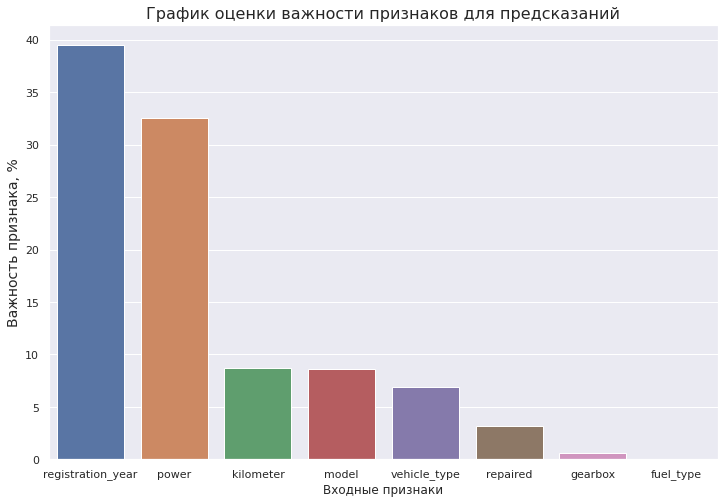

In [107]:
sns.barplot(cat_importances.T)
plt.title('График оценки важности признаков для предсказаний',
         fontsize=16)
plt.xlabel('Входные признаки')
plt.ylabel('Важность признака, %', fontsize=14)

plt.show()

1. Наибольшее влияние на предсказания модели оказывают признаки `registration_year` и `power`.
2. Наименьшее влияние оказывают признаки `fuel_type` и `gearbox`.

Дополнительно визуально рассмотрим и сравним предсказанные значения с истинными с помощью диаграмм рассеяния. Для начала подготовим данные для визуализации:

In [108]:
# Стоим датасет из предсказанных и истинных значений:
data = {
    'predicted': list(y_pred),
    'true': list(y_test)
}

comparison = pd.DataFrame(data)

# Проверка:
comparison.head(3)

,predicted,true
0,633.353520,400
1,2469.303561,5900
2,14449.496158,12870


Построим график:

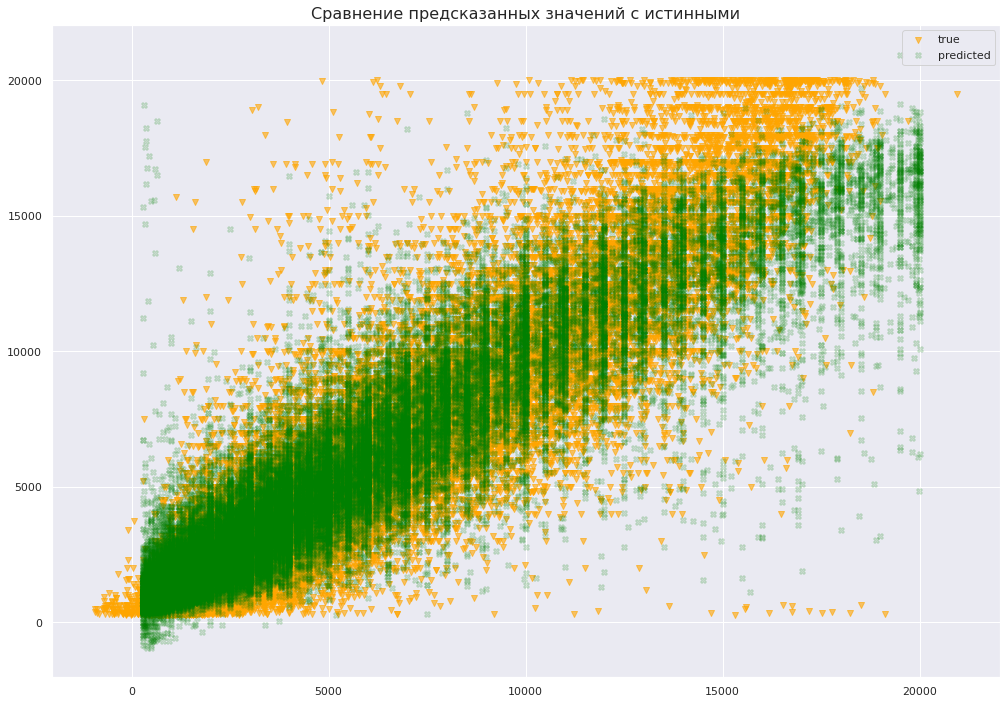

In [109]:
# Построение диаграммы рассеивания:
fig = plt.figure(figsize=(17,12))
ax = fig.add_subplot(111)

ax.scatter(data=comparison, x='predicted', y='true', color='orange', alpha=0.6, marker='v')
ax.scatter(data=comparison, x='true', y='predicted', color='green', alpha=0.15, marker='X')
plt.title('Сравнение предсказанных значений с истинными',
         fontsize=16)
plt.legend()

plt.show()

Хм. Похоже, модель склонна занижать свои предсказания относительно истинных. В целом, модель предсказывает неплохо.

## Общий вывод

Перед нами стояла задача **построения модели МО для определения рыночной стоимости автомобилей на основе имеющихся данных**, то есть задача _регрессии_.


Для решения этой задачи были проделаны следующие этапы:

1. **Исходные данные представляли собой датасет с входными признаками для объектов**. С ними было проведено ознакомление и проверка соответствия их описанию.
    
    - Исправили названия признаков;
    - Подправили типы данных у временны́х признаков;
    - Проверили данные на явные дубликаты и избавились от них;


2. **В процессе предобработки данных были обнаружены явные и неявные пропуски, а также некорректные значения**. От них мы избавились.



3. **Далее был проведён исследовательский анализ, на котором мы выяснили основные моменты**:

   
   - Данные всё ещё нуждаются в дополнительной обработке. Её мы проводили параллельно анализу.
     
     
   - Больше всего в выборке автомобилей с пробегом **более 140 тысяч км**, и чем пробег _меньше_, тем _меньше_ таких автомобилей;


   - Больше всего авто находится в ценовом диапазоне **до 1000 евро**;


   - Больше всего автомобилей в настоящей выборке имеет мощность в диапазоне **от 100 до 120 л.с**;


   - Лучше всего представлены _`седаны`_, из КПП — _`механическая`_, по марке — _`Volkswagen`_, _`BMW`_ и _`Opel`_;


   - Самый распространённый тип топлива — `бензиновое топливо`;


   - Абсолютное **большинство** объектов выборки **не были в ремонте**, по заявлению владельцев анкет;
   
   
   - Ближе к концу этапа избавились от ненужных неинформативных признаков;
  


4. **Мы провели корреляционный анализ**, чтобы понять, какие признаки могут сильно влиять на качество обучения в обе стороны. К сожалению, мы столкнулись с мультиколлинеарностью и дополнительными неинформативными признаками, которые особо не влияли на ценообразование. Итого:
    
    - _Мультиколлинеарность мы устранили_ путём удаления менее информативного признака, отвечающего за `брэнды`. 
    - Убрали шумные признаки.
    - Убрали новые явные дубликаты.


5. Далее **мы обучили и протестировали три модели машинного обучения**, две из которых основаны на бустинге. Все модели, конечно, прошли проверку на адекватность и показали разные результаты, которые нам пригодились, чтобы выбрать лучшую модель.


6. **Лучшей моделью** для решения нашей регрессионной задачи оказалась **_CatBoostRegressor_** со значением метрики RMSE в **1781.88** _на кросс-валидации_ и **1805.57** на проде (тестовых данных). Впоследстии мы выяснили, какие признаки больше всего оказывают влияние на предсказания:

    - Наибольшее влияние на предсказания модели оказывают признаки `год регистрации` и `мощность`.
    - Наименьшее влияние оказывают признаки `тип топлива` и `тип КПП`.


7. **Предупреждение для бизнеса**: скорее всего, модель склонна занижать цену. Имейте это в виду.